In [1]:
"""
This is based on the linear regression tutorial from tensorflow.
https://www.tensorflow.org/tutorials/keras/regression
"""

"Auto reload code"
%reload_ext autoreload
%autoreload 2

"Show plots in notebook"
%matplotlib inline

# Part 1:

## Data cleaning

In [2]:
import os
import pandas as pd

dataset_path = os.path.realpath('./auto-mpg.data')
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
df = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)\
                .dropna()

"""
Modify origin column using a one hot approach.
1: USA
2: Europe
3: Japan
"""
origin = df.pop('Origin')
df['USA'] = (origin == 1)*1.0
df['Europe'] = (origin == 2)*1.0
df['Japan'] = (origin == 3)*1.0

df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1.0,0.0,0.0


# Part 2:

## Split data into train and test datasets

,count,mean,std,min,25%,50%,75%,max
Cylinders,313.0,5.431310,1.702913,3.0,4.0,4.0,8.0,8.0
Displacement,313.0,191.369010,102.308367,68.0,105.0,146.0,260.0,455.0
Horsepower,313.0,103.479233,36.649243,46.0,76.0,94.0,122.0,225.0
Weight,313.0,2958.568690,829.644782,1613.0,2265.0,2790.0,3535.0,5140.0
Acceleration,313.0,15.596166,2.691258,8.0,13.8,15.5,17.3,24.6
Model Year,313.0,76.051118,3.702555,70.0,73.0,76.0,79.0,82.0
USA,313.0,0.613419,0.487746,0.0,0.0,1.0,1.0,1.0
Europe,313.0,0.169329,0.375643,0.0,0.0,0.0,0.0,1.0
Japan,313.0,0.217252,0.413036,0.0,0.0,0.0,0.0,1.0


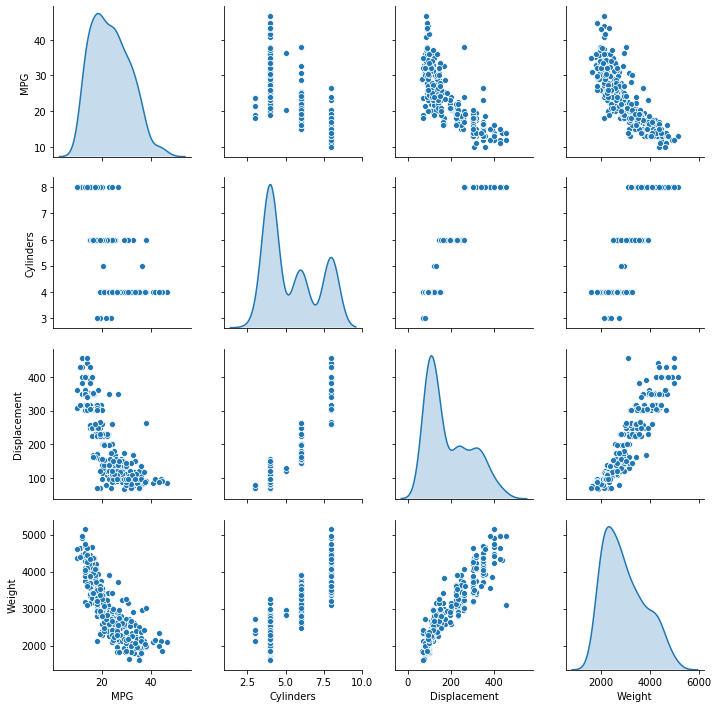

In [3]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=None)

import seaborn as sns
sns.pairplot(train_df[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

target_label = 'MPG'

"""
Gather some stats about the training data
"""
train_stats = train_df.describe()
train_stats.pop(target_label)
train_stats = train_stats.transpose()
display(train_stats)

"Remove label from the set of features. MPG (Miles per gallon) is what we're trying to predict"
train_labels = train_df.pop(target_label)
test_labels = test_df.pop(target_label)

# z-score
def norm(x):
    return (x - train_stats["mean"]) / train_stats["std"]

def denorm(x):
    return (x * train_stats["std"] + train_stats["mean"])

"Normalize data to make the model more performant as it helps it converge faster."
normed_train_df = norm(train_df)
normed_test_df = norm(test_df)

# Part 3

## Model definition

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)

"""
Define the network as a stack of layers
"""
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(normed_train_df.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae', 'mse'])

model.summary()

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

# Part 4

## Train the model

In [5]:
import datetime

# start tensorboard inside notebook
%reload_ext tensorboard
%tensorboard --logdir logs

"""
Custom callback for knowing when a certain epoch is done
"""
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
        
"If the model accuracy doesn't improve, stop training"
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
logdir = os.path.join('logs/notebook', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1)

"Train the model"
model.fit(
  normed_train_df, train_labels,
  epochs=1000, validation_split = 0.2,
  verbose=0, batch_size=512,
  callbacks=[
      tensorboard_callback,
      early_stop,
      PrintDot()
  ])

Reusing TensorBoard on port 6007 (pid 46600), started 0:02:39 ago. (Use '!kill 46600' to kill it.)

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter in device /job:localhost/replica:

# Part 5

## Evaluate model using test dataset

In [6]:
"Make predictions using test test dataset that the model haven't seen so far"
loss, mae, mse = model.evaluate(normed_test_df, test_labels, verbose=2)
print('Testing set Loss: {:5.2f}'.format(loss))
print("Testing set Mean Abs Error: {:5.2f}".format(mae))
print('Testing set Mean Square Error: {:5.2f}'.format(mse))

79/79 - 0s - loss: 7.3264 - mae: 2.1736 - mse: 7.3264
Testing set Loss:  7.33
Testing set Mean Abs Error:  2.17
Testing set Mean Square Error:  7.33


# Part 6

## Make predictions

Executing op __inference_keras_scratch_graph_24168 in device /job:localhost/replica:0/task:0/device:CPU:0


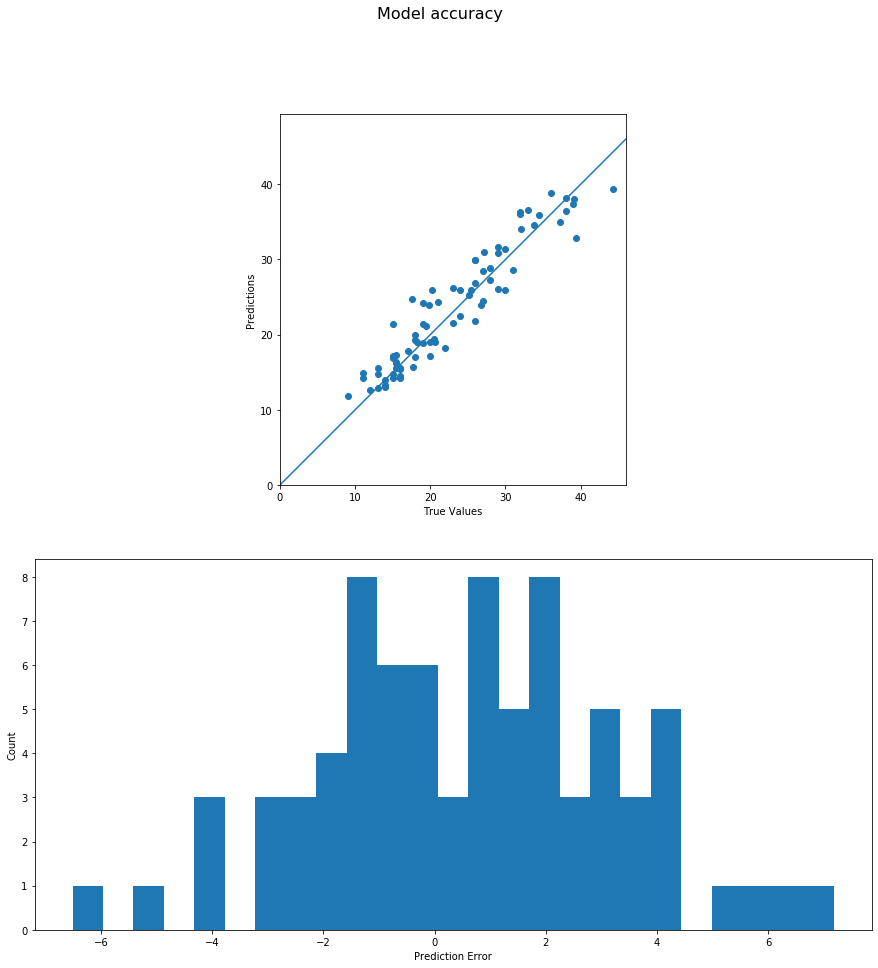

In [7]:
import matplotlib.pyplot as plt

test_predictions = model.predict(normed_test_df).flatten()

fig, (ax1, ax2) = plt.subplots(2, figsize=(15,15))
fig.suptitle('Model accuracy', fontsize=16)

ax1.scatter(test_labels, test_predictions)
ax1.set_xlabel('True Values')
ax1.set_ylabel('Predictions')
ax1.axis('equal')
ax1.axis('square')
ax1.set_xlim([0, ax1.get_xlim()[1]])
ax1.set_ylim([0, ax1.get_ylim()[1]])
ax1.plot([-100, 100], [-100, 100])

error = test_predictions - test_labels
ax2.hist(error, bins = 25)
ax2.set_xlabel("Prediction Error")
ax2.set_ylabel("Count")

plt.show()

# Part 7

## Save/load the model to disk for future use

In [8]:
"Save model to disk"

model.save('models/model.h5')

"Load model from disk"
loaded = keras.models.load_model('models/model.h5')
loaded.summary()

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [9]:
"Test if we still can do predictions"
batch_size = 10
normalized_example = normed_train_df[:batch_size]
combined = pd.concat([train_df[:batch_size], train_labels[:batch_size]], axis=1)
combined["Prediction"] = loaded.predict(normalized_example)
display(combined)

Executing op __inference_keras_scratch_graph_24928 in device /job:localhost/replica:0/task:0/device:CPU:0


,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan,MPG,Prediction
183,4,116.0,81.0,2220.0,16.9,76,0.0,1.0,0.0,25.0,27.747858
219,4,122.0,96.0,2300.0,15.5,77,1.0,0.0,0.0,25.5,26.005844
14,4,113.0,95.0,2372.0,15.0,70,0.0,0.0,1.0,24.0,21.692619
339,4,151.0,84.0,2635.0,16.4,81,1.0,0.0,0.0,26.6,28.089403
226,6,231.0,105.0,3425.0,16.9,77,1.0,0.0,0.0,20.5,18.049473
218,4,79.0,58.0,1825.0,18.6,77,0.0,1.0,0.0,36.0,34.702545
71,3,70.0,97.0,2330.0,13.5,72,0.0,0.0,1.0,19.0,23.597595
66,8,304.0,150.0,3672.0,11.5,72,1.0,0.0,0.0,17.0,15.752176
305,4,151.0,90.0,2670.0,16.0,79,1.0,0.0,0.0,28.4,25.316267
280,6,231.0,115.0,3245.0,15.4,79,1.0,0.0,0.0,21.5,19.609692
